In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import wandb
from keras.datasets import fashion_mnist
from PIL import Image

## Question-01

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: yeshu183 (yeshu183-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


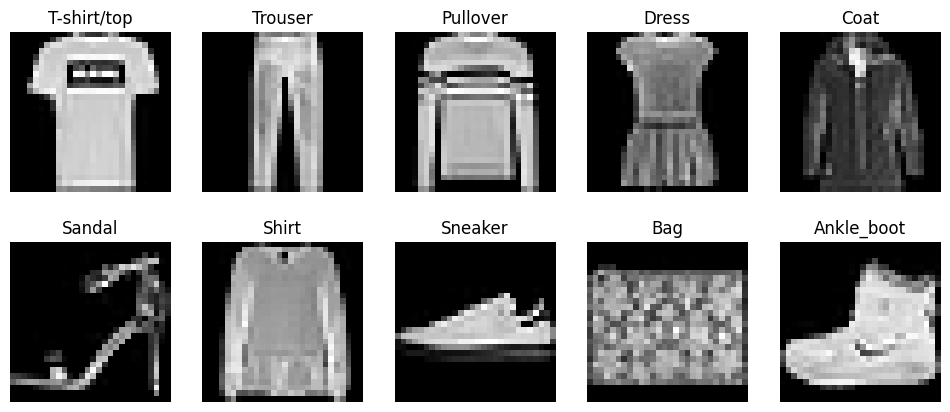

In [3]:
# Initialize wandb
wandb.init(project="fashion-mnist-classes")

# Load dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Class labels in Fashion-MNIST
class_labels = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle_boot"
]
plt.figure(figsize=[12, 5])

# Select one image per class
sample_images = {}
st = set()
for x,y in zip(x_train,y_train):
    if y in st:
      continue
    else:
      st.add(y)
      sample_images[class_labels[y]] = wandb.Image(x)
      plt.subplot(2, 5, y+1)
      plt.imshow(x, cmap='gray')
      plt.axis('off')
      plt.title(class_labels[y])

# Log images to wandb
wandb.log({"fashion-mnist-classes": [wandb.Image(img,caption=caption) for caption,img in sample_images.items()]})

# Finish wandb run API Key: f659082c2b19bf3ffaaceceb36c1e280541f6b11
wandb.finish()

##Question-02

In [3]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
# Split validation set (10% of training data)
val_size = int(0.1 * len(x_train))
x_val, y_val = x_train[:val_size], y_train[:val_size]
x_train, y_train = x_train[val_size:], y_train[val_size:]

# Normalize inputs
x_train = x_train.reshape(x_train.shape[0], -1) / 255.0
x_val = x_val.reshape(x_val.shape[0], -1) / 255.0
x_test = x_test.reshape(x_test.shape[0], -1) / 255.0

# One-hot encoding of labels
def one_hot_encode(y, num_classes=10):
    return np.eye(num_classes)[y]

y_train = one_hot_encode(y_train)
y_val = one_hot_encode(y_val)
y_test = one_hot_encode(y_test)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
wandb.finish()

In [7]:
import numpy as np

class Optimizers:
    def __init__(self, lr=1e-3, epsilon=1e-8):
        self.lr = lr
        self.epsilon = epsilon  # Small value to prevent division by zero

        # Initialize state dictionaries
        self.v = {}  # Velocity (for momentum, NAG)
        self.s = {}  # Squared gradients (for RMSprop, Adam, Nadam)
        self.m = {}  # First moment (for Adam/Nadam)
        self.t = 0   # Time step (for Adam/Nadam)

    def _initialize_params(self, w_key):
        """Initialize optimizer states for a given parameter key"""
        if w_key not in self.v:
            self.v[w_key] = np.zeros_like(w_key)
            self.s[w_key] = np.zeros_like(w_key)
            self.m[w_key] = np.zeros_like(w_key)

    def sgd(self, w, b, dw, db):
        """Vanilla Stochastic Gradient Descent"""
        w -= self.lr * dw
        b -= self.lr * db
        return w, b

    def momentum(self, w, b, dw, db, key="w", beta1=0.9):
        """Momentum-based Gradient Descent"""
        self._initialize_params(key)
        self.v[key] = beta1 * self.v[key] - self.lr * dw
        w += self.v[key]
        b -= self.lr * db
        return w, b

    def nesterov(self, w, b, dw, db, key="w", beta1=0.9):
        """Nesterov Accelerated Gradient (NAG)"""
        self._initialize_params(key)
        prev_v = self.v[key]
        self.v[key] = beta1 * self.v[key] - self.lr * dw
        w += -beta1 * prev_v + (1 + beta1) * self.v[key]
        b -= self.lr * db
        return w, b

    def rmsprop(self, w, b, dw, db, key="w", rho=0.9):
        """RMSprop Optimization"""
        self._initialize_params(key)
        self.s[key] = rho * self.s[key] + (1 - rho) * (dw ** 2)
        w -= self.lr * dw / (np.sqrt(self.s[key]) + self.epsilon)
        b -= self.lr * db
        return w, b

    def adam(self, w, b, dw, db, key="w", beta1=0.9, beta2=0.999):
        """Adaptive Moment Estimation (Adam)"""
        self._initialize_params(key)
        self.t += 1  # Time step
        self.m[key] = beta1 * self.m[key] + (1 - beta1) * dw
        self.s[key] = beta2 * self.s[key] + (1 - beta2) * (dw ** 2)

        m_hat = self.m[key] / (1 - beta1 ** self.t)
        s_hat = self.s[key] / (1 - beta2 ** self.t)

        w -= self.lr * m_hat / (np.sqrt(s_hat) + self.epsilon)
        b -= self.lr * db
        return w, b

    def nadam(self, w, b, dw, db, key="w", beta1=0.9, beta2=0.999):
        """Nadam Optimization (Adam + Nesterov)"""
        self._initialize_params(key)
        self.t += 1  # Time step
        self.m[key] = beta1 * self.m[key] + (1 - beta1) * dw
        self.s[key] = beta2 * self.s[key] + (1 - beta2) * (dw ** 2)

        m_hat = self.m[key] / (1 - beta1 ** self.t)
        s_hat = self.s[key] / (1 - beta2 ** self.t)

        m_nesterov = beta1 * m_hat + (1 - beta1) * dw / (1 - beta1 ** self.t)

        w -= self.lr * m_nesterov / (np.sqrt(s_hat) + self.epsilon)
        b -= self.lr * db
        return w, b


In [6]:
# Define activation functions class
class ActivationFunctions:
    def sigmoid(z):
        return 1 / (1 + np.exp(-z))

    def tanh(z):
        return np.tanh(z)

    def relu(z):
        return np.maximum(0, z)

    def softmax(z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

In [13]:
from os import access
# Initialize Weights & Biases (wandb)
wandb.init(project="Neural Network class")



# Define weight initialization methods
def random_init(shape):
    return np.random.randn(*shape) * 0.01

def xavier_init(shape):
    return np.random.randn(*shape) * np.sqrt(1 / shape[0])

# Define gradient descent algorithms class
# class Optimizers:
#     def __init__(self, lr=1e-3):
#         self.lr = lr

#     def sgd(self, w, b, dw, db):
#         w -= self.lr * dw
#         b -= self.lr * db
#         return w, b
# Define the neural network class
class NeuralNetwork:
    def __init__(self, input_size,num_hid_layers, hid_layer_size, output_size=10, activation='relu', weight_init='random', l2_reg=0.0, optimizer='sgd', lr=1e-3):
        self.layers = [input_size] + num_hid_layers*[hid_layer_size] + [output_size]
        self.activation_func = getattr(ActivationFunctions, activation)
        self.weight_init = {'random': random_init, 'xavier': xavier_init}[weight_init]
        self.l2_reg = l2_reg
        self.optimizer = Optimizers(lr)  # Create an instance of Optimizers
        self.optimizer_function = getattr(self.optimizer, optimizer)
        self.weights = [self.weight_init((self.layers[i], self.layers[i+1])) for i in range(len(self.layers) - 1)]
        self.biases = [self.weight_init((1, self.layers[i+1])) for i in range(len(self.layers) - 1)]

    def forward(self, x):
        activations = [x]
        z_values = []
        for i in range(len(self.weights) - 1):
            z = np.dot(x, self.weights[i]) + self.biases[i]
            a = self.activation_func(z)
            z_values.append(z)
            activations.append(a)
        z = np.dot(x, self.weights[-1]) + self.biases[-1]
        a = ActivationFunctions.softmax(z)
        z_values.append(z)
        activations.append(a)
        return activations, z_values

    def compute_loss(self, y_pred, y_true):
        l2_penalty = self.l2_reg * sum(np.sum(w**2) for w in self.weights) / 2
        return -np.mean(y_true * np.log(y_pred + 1e-9)) + l2_penalty

    def compute_accuracy(self, y_pred, y_true):
        # Convert one-hot encoded true labels to class indices
        y_true_labels = np.argmax(y_true, axis=1)
        # Convert predicted probabilities to class indices
        y_pred_labels = np.argmax(y_pred, axis=1)
        # Compute accuracy
        accuracy = np.mean(y_pred_labels == y_true_labels)
        return accuracy


    def backward(self, activations, z_values, y_true):
        """
        Perform backpropagation with different activation functions.

        Parameters:
        - activations: List of activations from each layer.
        - z_values: List of pre-activation values (Z) from each layer.
        - y_true: True labels.
        - activation_funcs: List of activation functions used in each layer.

        Returns:
        - grad_weights: Gradients for weights.
        - grad_biases: Gradients for biases.
        """
        grad_weights = [None] * len(self.weights)
        grad_biases = [None] * len(self.biases)

        # Derivative functions for activation functions
        def relu_derivative(z):
            return (z > 0).astype(float)

        def tanh_derivative(z):
            return 1 - np.tanh(z) ** 2

        def sigmoid_derivative(z):
            sig = 1 / (1 + np.exp(-z))
            return sig * (1 - sig)

        def softmax_derivative(a):
            return a * (1 - a)  # Not directly used in CE loss

        # Output layer gradient
        dz = activations[-1] - y_true  # Cross-entropy with softmax simplifies to this

        grad_weights[-1] = np.dot(activations[-2].T, dz) / len(y_true)
        grad_biases[-1] = np.sum(dz, axis=0, keepdims=True) / len(y_true)

        # Backpropagation through hidden layers
        for i in range(len(self.weights) - 2, -1, -1):
            if activation == "relu":
                dz = np.dot(dz, self.weights[i + 1].T) * relu_derivative(z_values[i])
            elif activation == "tanh":
                dz = np.dot(dz, self.weights[i + 1].T) * tanh_derivative(z_values[i])
            elif activation == "sigmoid":
                dz = np.dot(dz, self.weights[i + 1].T) * sigmoid_derivative(z_values[i])
            else:
                raise ValueError(f"Unsupported activation function: {activation}")

            grad_weights[i] = np.dot(activations[i].T, dz) / len(y_true)
            grad_biases[i] = np.sum(dz, axis=0, keepdims=True) / len(y_true)

        return grad_weights, grad_biases


    def update_parameters(self, grad_weights, grad_biases, optimizer_function, lr):
      for i in range(len(self.weights)):
          self.weights[i], self.biases[i] = optimizer_function(self.weights[i], self.biases[i], grad_weights[i], grad_biases[i])


    def train(self, x, y, epochs=10, batch_size=32):
        for epoch in range(epochs):
            indices = np.arange(len(x))
            np.random.shuffle(indices)
            for i in range(0, len(x), batch_size):
                batch_indices = indices[i:i+batch_size]
                x_batch, y_batch = x[batch_indices], y[batch_indices]
                activations, z_values = self.forward(x_batch)
                loss = self.compute_loss(activations[-1], y_batch)
                accuracy = self.compute_accuracy(activations[-1], y_batch)
                grad_weights, grad_biases = self.backward(activations, z_values, y_batch)
                self.update_parameters(grad_weights, grad_biases, self.optimizer_function, self.optimizer.lr)
                #wandb.log({"loss": loss, "accuracy": accuracy})
            print(f"Epoch {epoch+1}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

# Hyperparameters
hidden_layers = [32, 64, 128]  # Changeable number of layers
weight_init = 'xavier'  # Options: 'random', 'xavier'
activation = 'relu'  # Options: 'sigmoid', 'tanh', 'relu'
l2_reg = 0.0005  # L2 regularization strength
learning_rate = 1e-3  # Options: 1e-3, 1e-4
batch_size = 32  # Options: 16, 32, 64
epochs = 5  # Options: 5, 10
optimizer = 'sgd'  # Options: 'sgd', 'momentum', 'nesterov', 'rmsprop', 'adam', 'nadam'

# Initialize and train the model
nn = NeuralNetwork(input_size=784, hidden_layers=hidden_layers, activation=activation, weight_init=weight_init, l2_reg=l2_reg, optimizer=optimizer, lr=learning_rate)
nn.train(x_train, y_train, epochs=epochs, batch_size=batch_size)

wandb.finish()


Epoch 1, Loss: 0.1938
Epoch 2, Loss: 0.1618
Epoch 3, Loss: 0.1330
Epoch 4, Loss: 0.1499
Epoch 5, Loss: 0.1288


loss,█████▇▇▄▄▃▃▃▃▃▃▂▃▃▂▂▂▁▁▂▁▁▂▂▁▂▁▂▂▁▂▁▂▂▂▂
loss,0.12875


##Question-4

In [ ]:
# Initialize Weights & Biases (wandb)
wandb.finish()


# Define sweep configuration
sweep_config = {
    'method': 'bayes',  # Options: grid, random, bayes
    'metric': {'name': 'val_acc', 'goal': 'maximize'},
    'parameters': {
        'epochs': {'values': [5]},
        'hidden_layers': {'values': [[32, 64, 128], [64, 128, 256], [128, 256, 512]]},
        'weight_init': {'values': ['random', 'xavier']},
        'activation': {'values': ['sigmoid', 'tanh', 'relu']},
        'l2_reg': {'values': [0, 0.0005, 0.5]},
        'learning_rate': {'values': [1e-3, 1e-4]},
        'batch_size': {'values': [16, 32, 64]},
        'optimizer': {'values': ['sgd']}
    }
}

sweep_id = wandb.sweep(sweep_config, project="Sweep Functionality")

def train_sweep():
    wandb.init(project="Sweep Functionality")
    config = wandb.config
    wandb.run.name = f"e_{config.epochs}_hl_{config.hidden_layers}_opt_{config.optimizer}_bs_{config.batch_size}_init_{config.weight_init}_ac_{config.activation}"

    nn = NeuralNetwork(
        input_size=784,
        hidden_layers=config.hidden_layers,
        activation=config.activation,
        weight_init=config.weight_init,
        l2_reg=config.l2_reg,
        optimizer=config.optimizer,
        lr=config.learning_rate
    )

    nn.train(x_train, y_train, epochs=config.epochs, batch_size=config.batch_size)

    val_activations,val_z = nn.forward(x_val)
    val_loss = nn.compute_loss(val_activations[-1], y_val)
    val_acc = nn.compute_accuracy(val_activations[-1], y_val)
    wandb.log({"val_loss": val_loss, "val_acc": val_acc})
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

wandb.agent(sweep_id, function=train_sweep)
wandb.finish()

Create sweep with ID: x54z7171
Sweep URL: https://wandb.ai/yeshu183-indian-institute-of-technology-madras/Sweep%20Functionality/sweeps/x54z7171


wandb: Agent Starting Run: ubnuf2bk with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: [64, 128, 256]
wandb: 	l2_reg: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_init: xavier


Epoch 1, Loss: 115.1918
Epoch 2, Loss: 115.2192
Epoch 3, Loss: 115.2727
Epoch 4, Loss: 115.3420
Epoch 5, Loss: 115.4375
Validation Loss: 115.4334, Validation Accuracy: 0.5328


loss,▄▁▂▂▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▄▆▆▆▇▇▇████
val_acc,▁
val_loss,▁
loss,115.43745
val_acc,0.53283
val_loss,115.43342


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 285jonqj with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.2290
Epoch 2, Loss: 0.2297
Epoch 3, Loss: 0.2275
Epoch 4, Loss: 0.2250
Epoch 5, Loss: 0.2162
Validation Loss: 0.2217, Validation Accuracy: 0.2417


loss,▇█▅▄▄▅▅▄▄▄▄▅▄▄▄▄▅▄▄▄▃▄▄▄▃▄▂▃▃▄▃▃▃▃▃▁▂▃▂▃
val_acc,▁
val_loss,▁
loss,0.21624
val_acc,0.24167
val_loss,0.2217


wandb: Agent Starting Run: hoci7pma with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: [128, 256, 512]
wandb: 	l2_reg: 0.0005
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.3226
Epoch 2, Loss: 0.2912
Epoch 3, Loss: 0.2980
Epoch 4, Loss: 0.2823
Epoch 5, Loss: 0.3203
Validation Loss: 0.2886, Validation Accuracy: 0.7853


loss,█▇▇▇▆▅▅▄▄▄▂▂▃▃▂▃▃▃▂▃▃▂▂▂▂▂▁▁▁▂▁▁▁▂▂▁▂▂▁▂
val_acc,▁
val_loss,▁
loss,0.32028
val_acc,0.78533
val_loss,0.28857


wandb: Agent Starting Run: 7vfpzun3 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: [128, 256, 512]
wandb: 	l2_reg: 0.0005
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.3973
Epoch 2, Loss: 0.3413
Epoch 3, Loss: 0.3171
Epoch 4, Loss: 0.3046
Epoch 5, Loss: 0.2886
Validation Loss: 0.3013, Validation Accuracy: 0.7457


loss,█▇▇▇▇▆▆▆▅▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▁▂▂▂▂▂▁▂▁▂▂▂▂▁▂▂
val_acc,▁
val_loss,▁
loss,0.28862
val_acc,0.74567
val_loss,0.30126


wandb: Agent Starting Run: 35a094oj with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: [128, 256, 512]
wandb: 	l2_reg: 0.5
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_init: xavier


Epoch 1, Loss: 227.8701
Epoch 2, Loss: 228.5441
Epoch 3, Loss: 229.1410
Epoch 4, Loss: 229.6056
Epoch 5, Loss: 230.0077
Validation Loss: 230.0090, Validation Accuracy: 0.7465


loss,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
val_acc,▁
val_loss,▁
loss,230.00775
val_acc,0.7465
val_loss,230.00897


wandb: Agent Starting Run: zodd5ml4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: [128, 256, 512]
wandb: 	l2_reg: 0.5
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_init: xavier


Epoch 1, Loss: 226.6031
Epoch 2, Loss: 227.3106
Epoch 3, Loss: 227.9486
Epoch 4, Loss: 228.4362
Epoch 5, Loss: 228.8566
Validation Loss: 228.8422, Validation Accuracy: 0.7570


loss,▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███████
val_acc,▁
val_loss,▁
loss,228.85656
val_acc,0.757
val_loss,228.84222


wandb: Agent Starting Run: liek84vp with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: [128, 256, 512]
wandb: 	l2_reg: 0.5
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_init: xavier


Epoch 1, Loss: 227.8531
Epoch 2, Loss: 228.5770
Epoch 3, Loss: 229.1949
Epoch 4, Loss: 229.6972
Epoch 5, Loss: 230.1066
Validation Loss: 230.1144, Validation Accuracy: 0.7410


loss,▁▁▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
val_acc,▁
val_loss,▁
loss,230.10663
val_acc,0.741
val_loss,230.11439


wandb: Agent Starting Run: am9lpr8j with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: [128, 256, 512]
wandb: 	l2_reg: 0.5
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_init: random


Epoch 1, Loss: 6.9981
Epoch 2, Loss: 6.9983
Epoch 3, Loss: 6.9981
Epoch 4, Loss: 6.9985
Epoch 5, Loss: 6.9987
Validation Loss: 6.9987, Validation Accuracy: 0.0983


loss,▃▁▃▂▃▂▃▁▆▂▃▃▃▃▄▃▆▄▅▅▄▃▄▄▄▄▄▅▅▂▅▅▃▆▇▆▇▇▇█
val_acc,▁
val_loss,▁
loss,6.99871
val_acc,0.09833
val_loss,6.99866


wandb: Agent Starting Run: 7bk6sbmz with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: [128, 256, 512]
wandb: 	l2_reg: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_init: xavier


Epoch 1, Loss: 228.3557
Epoch 2, Loss: 228.3647
Epoch 3, Loss: 228.3773
Epoch 4, Loss: 228.3954
Epoch 5, Loss: 228.4144
Validation Loss: 228.4160, Validation Accuracy: 0.4103


loss,▅▁▁▁▁▁▁▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇███
val_acc,▁
val_loss,▁
loss,228.41445
val_acc,0.41033
val_loss,228.416


wandb: Agent Starting Run: w9l7bf8y with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: [128, 256, 512]
wandb: 	l2_reg: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.4530
Epoch 2, Loss: 0.4466
Epoch 3, Loss: 0.4408
Epoch 4, Loss: 0.4328
Epoch 5, Loss: 0.4244
Validation Loss: 0.4231, Validation Accuracy: 0.5868


loss,▇██▇▆▅▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▂▃▃▃▂▂▃▂▂▂▂▂▂▁▂▁▁
val_acc,▁
val_loss,▁
loss,0.42443
val_acc,0.58683
val_loss,0.42312


wandb: Agent Starting Run: fa2do1v2 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: [128, 256, 512]
wandb: 	l2_reg: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.4540
Epoch 2, Loss: 0.4462
Epoch 3, Loss: 0.4393
Epoch 4, Loss: 0.4317
Epoch 5, Loss: 0.4262
Validation Loss: 0.4232, Validation Accuracy: 0.5280


loss,█▅▅▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁
val_acc,▁
val_loss,▁
loss,0.42616
val_acc,0.528
val_loss,0.42318


wandb: Agent Starting Run: ezxdoq2b with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: [128, 256, 512]
wandb: 	l2_reg: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.4487
Epoch 2, Loss: 0.4345
Epoch 3, Loss: 0.4272
Epoch 4, Loss: 0.4144
Epoch 5, Loss: 0.3878
Validation Loss: 0.3871, Validation Accuracy: 0.5997


loss,▆█▇▆▆▆▆▆▆▆▅▅▅▅▆▅▅▅▅▅▄▄▄▄▄▃▄▄▃▂▂▃▂▃▂▂▂▁▁▂
val_acc,▁
val_loss,▁
loss,0.38778
val_acc,0.59967
val_loss,0.3871


wandb: Agent Starting Run: r8gvyooy with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: [128, 256, 512]
wandb: 	l2_reg: 0.0005
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.3727
Epoch 2, Loss: 0.3518
Epoch 3, Loss: 0.3200
Epoch 4, Loss: 0.2976
Epoch 5, Loss: 0.3045
Validation Loss: 0.3014, Validation Accuracy: 0.7545


loss,███▇▇▆▅▅▄▄▃▃▃▃▃▃▂▃▃▂▂▂▂▂▃▂▁▁▁▁▁▂▁▁▁▁▁▁▁▂
val_acc,▁
val_loss,▁
loss,0.30455
val_acc,0.7545
val_loss,0.30142


wandb: Agent Starting Run: pnm0mc24 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: [128, 256, 512]
wandb: 	l2_reg: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_init: xavier


Epoch 1, Loss: 226.4967
Epoch 2, Loss: 226.5363
Epoch 3, Loss: 226.6068
Epoch 4, Loss: 226.7080
Epoch 5, Loss: 226.8291
Validation Loss: 226.8356, Validation Accuracy: 0.6197


loss,▁▁▁▁▁▁▁▁▁▂▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▆▆▇▇▇▇████
val_acc,▁
val_loss,▁
loss,226.82909
val_acc,0.61967
val_loss,226.83556


wandb: Agent Starting Run: b3dhhu8x with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: [128, 256, 512]
wandb: 	l2_reg: 0.5
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_init: xavier


Epoch 1, Loss: 226.9394
Epoch 2, Loss: 227.6379
Epoch 3, Loss: 228.2265
Epoch 4, Loss: 228.7128
Epoch 5, Loss: 229.1383
Validation Loss: 229.1265, Validation Accuracy: 0.7472


loss,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
val_acc,▁
val_loss,▁
loss,229.13829
val_acc,0.74717
val_loss,229.12648


wandb: Agent Starting Run: 7pzryp9b with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: [128, 256, 512]
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.2264
Epoch 2, Loss: 0.2169
Epoch 3, Loss: 0.2119
Epoch 4, Loss: 0.2073
Epoch 5, Loss: 0.1988
Validation Loss: 0.1992, Validation Accuracy: 0.5270


loss,█▄▄▄▃▄▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_acc,▁
val_loss,▁
loss,0.19878
val_acc,0.527
val_loss,0.19917


wandb: Agent Starting Run: e4lbg8gx with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: [128, 256, 512]
wandb: 	l2_reg: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_init: xavier


Epoch 1, Loss: 226.1758
Epoch 2, Loss: 226.2154
Epoch 3, Loss: 226.2845
Epoch 4, Loss: 226.3930
Epoch 5, Loss: 226.5064
Validation Loss: 226.5033, Validation Accuracy: 0.5995


loss,▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▄▃▄▄▄▅▆▆▆▆▇▇▇██
val_acc,▁
val_loss,▁
loss,226.50642
val_acc,0.5995
val_loss,226.50334


wandb: Agent Starting Run: hf0j1bwv with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: [128, 256, 512]
wandb: 	l2_reg: 0.0005
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.3925
Epoch 2, Loss: 0.3414
Epoch 3, Loss: 0.3243
Epoch 4, Loss: 0.3141
Epoch 5, Loss: 0.3124
Validation Loss: 0.3030, Validation Accuracy: 0.7505


loss,███▇▅▅▅▄▄▄▄▄▄▄▃▃▂▂▃▃▃▂▂▂▃▂▂▂▂▂▂▂▁▂▂▁▁▁▂▁
val_acc,▁
val_loss,▁
loss,0.31242
val_acc,0.7505
val_loss,0.30297


wandb: Agent Starting Run: u95q31ue with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: [128, 256, 512]
wandb: 	l2_reg: 0.0005
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.3807
Epoch 2, Loss: 0.3252
Epoch 3, Loss: 0.3270
Epoch 4, Loss: 0.2919
Epoch 5, Loss: 0.2917
Validation Loss: 0.3023, Validation Accuracy: 0.7483


loss,███▇▇▆▆▅▅▄▄▄▅▄▃▄▃▂▃▃▂▂▂▂▂▁▂▂▁▁▂▁▁▁▁▂▁▁▂▁
val_acc,▁
val_loss,▁
loss,0.29174
val_acc,0.74833
val_loss,0.30227


wandb: Agent Starting Run: a04n0hdr with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: [128, 256, 512]
wandb: 	l2_reg: 0.0005
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.3839
Epoch 2, Loss: 0.3277
Epoch 3, Loss: 0.3094
Epoch 4, Loss: 0.3171
Epoch 5, Loss: 0.2852
Validation Loss: 0.3025, Validation Accuracy: 0.7437


loss,██▇▆▆▅▅▄▅▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▁▁▁▂▁▂▁▂▁▁▁▁▁▂▁▁
val_acc,▁
val_loss,▁
loss,0.28519
val_acc,0.74367
val_loss,0.30245


wandb: Agent Starting Run: 3104aumo with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: [128, 256, 512]
wandb: 	l2_reg: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.4457
Epoch 2, Loss: 0.4337
Epoch 3, Loss: 0.4208
Epoch 4, Loss: 0.4217
Epoch 5, Loss: 0.4075
Validation Loss: 0.3952, Validation Accuracy: 0.6453


loss,██▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▅▅▅▅▅▄▅▄▄▄▄▅▃▃▃▂▃▃▁▁▃▂▁
val_acc,▁
val_loss,▁
loss,0.40746
val_acc,0.64533
val_loss,0.39522


wandb: Agent Starting Run: rfm2198c with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: [128, 256, 512]
wandb: 	l2_reg: 0.0005
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.3259
Epoch 2, Loss: 0.3055
Epoch 3, Loss: 0.2904
Epoch 4, Loss: 0.2748
Epoch 5, Loss: 0.2644
Validation Loss: 0.2883, Validation Accuracy: 0.7922


loss,█▇▇▇▆▅▅▄▄▄▄▄▄▃▃▂▃▂▂▂▃▂▃▂▂▂▃▂▂▁▂▃▂▂▂▂▂▁▁▂
val_acc,▁
val_loss,▁
loss,0.26436
val_acc,0.79217
val_loss,0.28831


wandb: Agent Starting Run: w9llt0rl with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: [128, 256, 512]
wandb: 	l2_reg: 0.0005
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.3939
Epoch 2, Loss: 0.3414
Epoch 3, Loss: 0.3198
Epoch 4, Loss: 0.3002
Epoch 5, Loss: 0.3006
Validation Loss: 0.3024, Validation Accuracy: 0.7482


loss,█▇▇▇▇▆▆▆▅▅▄▄▄▄▄▃▂▂▃▂▂▃▃▂▂▁▂▂▂▃▂▃▂▂▁▂▁▂▂▁
val_acc,▁
val_loss,▁
loss,0.30057
val_acc,0.74817
val_loss,0.30242


wandb: Agent Starting Run: bnkqnr5j with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_init: random


Epoch 1, Loss: 0.2302
Epoch 2, Loss: 0.2302
Epoch 3, Loss: 0.2303
Epoch 4, Loss: 0.2304
Epoch 5, Loss: 0.2303
Validation Loss: 0.2303, Validation Accuracy: 0.0983


loss,▆▁▅▅▂▃▅▁▅▅▅▇▅█▃▄▅▃█▃▅▃▄▄▆▅▄▃▅▃▄▆▃▄█▆▃▂▅▅
val_acc,▁
val_loss,▁
loss,0.23028
val_acc,0.09833
val_loss,0.23026


wandb: Agent Starting Run: zcwhhpiw with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: [128, 256, 512]
wandb: 	l2_reg: 0.0005
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.4317
Epoch 2, Loss: 0.4014
Epoch 3, Loss: 0.3900
Epoch 4, Loss: 0.3664
Epoch 5, Loss: 0.3535
Validation Loss: 0.3634, Validation Accuracy: 0.6527


loss,█████▇▇▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▂▂▂▁▁▂▁▁
val_acc,▁
val_loss,▁
loss,0.35353
val_acc,0.65267
val_loss,0.36335


wandb: Agent Starting Run: 45gkv05y with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: [128, 256, 512]
wandb: 	l2_reg: 0.5
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_init: xavier


Epoch 1, Loss: 226.7133
Epoch 2, Loss: 227.4459
Epoch 3, Loss: 228.0643
Epoch 4, Loss: 228.5692
Epoch 5, Loss: 228.9546
Validation Loss: 228.9634, Validation Accuracy: 0.7523


loss,▁▁▁▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇███████
val_acc,▁
val_loss,▁
loss,228.95461
val_acc,0.75233
val_loss,228.96342


wandb: Agent Starting Run: fm2odxbe with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: [128, 256, 512]
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_init: random


Epoch 1, Loss: 0.2305
Epoch 2, Loss: 0.2311
Epoch 3, Loss: 0.2299
Epoch 4, Loss: 0.2303
Epoch 5, Loss: 0.2298
Validation Loss: 0.2303, Validation Accuracy: 0.1028


loss,█▄▄▃▂▃▃▄▃▃▅▃▅▂▂▄▂▃▅▃▂▁▃▅▅▃▃▂▄▁▃▃▂▃▄▂▃▃▄▃
val_acc,▁
val_loss,▁
loss,0.2298
val_acc,0.10283
val_loss,0.23027


wandb: Agent Starting Run: 4wngry7x with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: [128, 256, 512]
wandb: 	l2_reg: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.4327
Epoch 2, Loss: 0.4063
Epoch 3, Loss: 0.3817
Epoch 4, Loss: 0.3474
Epoch 5, Loss: 0.3315
Validation Loss: 0.3401, Validation Accuracy: 0.6992


loss,█▆▆▆▆▆▆▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▂▂▂▂▃▃▃▂▂▂▃▂▂▂▁▂▂
val_acc,▁
val_loss,▁
loss,0.33154
val_acc,0.69917
val_loss,0.34013


wandb: Agent Starting Run: l1s83g31 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: [128, 256, 512]
wandb: 	l2_reg: 0.5
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_init: xavier


Epoch 1, Loss: 227.3394
Epoch 2, Loss: 233.9024
Epoch 3, Loss: 266.1062
Epoch 4, Loss: 462.2071
Epoch 5, Loss: 1591.0564
Validation Loss: 1591.6683, Validation Accuracy: 0.2747


loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▄▅▆▆█
val_acc,▁
val_loss,▁
loss,1591.05639
val_acc,0.27467
val_loss,1591.66831


wandb: Agent Starting Run: 7rrij96q with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: [128, 256, 512]
wandb: 	l2_reg: 0.5
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_init: xavier


Epoch 1, Loss: 228.0710
Epoch 2, Loss: 229.1553
Epoch 3, Loss: 229.8941
Epoch 4, Loss: 230.4787
Epoch 5, Loss: 230.9346
Validation Loss: 230.9322, Validation Accuracy: 0.7840


loss,▁▁▁▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█████
val_acc,▁
val_loss,▁
loss,230.93462
val_acc,0.784
val_loss,230.93222


wandb: Agent Starting Run: i61nmmvp with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	l2_reg: 0.5
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_init: xavier


Epoch 1, Loss: 60.1341
Epoch 2, Loss: 61.2568
Epoch 3, Loss: 62.1668
Epoch 4, Loss: 62.8504
Epoch 5, Loss: 63.3057
Validation Loss: 63.3144, Validation Accuracy: 0.7677


loss,▁▁▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇███████
val_acc,▁
val_loss,▁
loss,63.30566
val_acc,0.76767
val_loss,63.31441


wandb: Agent Starting Run: bmw0adi2 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: [128, 256, 512]
wandb: 	l2_reg: 0.0005
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.3895
Epoch 2, Loss: 0.3508
Epoch 3, Loss: 0.3198
Epoch 4, Loss: 0.3025
Epoch 5, Loss: 0.3102
Validation Loss: 0.3015, Validation Accuracy: 0.7468


loss,█▆▆▆▅▅▅▄▄▃▃▃▃▃▃▂▃▃▃▂▂▂▂▂▂▂▂▂▁▂▂▂▁▂▁▁▂▂▂▁
val_acc,▁
val_loss,▁
loss,0.31024
val_acc,0.74683
val_loss,0.30148


wandb: Agent Starting Run: kadvjd4g with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: [64, 128, 256]
wandb: 	l2_reg: 0.5
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_init: xavier


Epoch 1, Loss: 116.2560
Epoch 2, Loss: 117.5893
Epoch 3, Loss: 118.4269
Epoch 4, Loss: 119.0704
Epoch 5, Loss: 119.6308
Validation Loss: 119.6232, Validation Accuracy: 0.8253


loss,▁▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇████
val_acc,▁
val_loss,▁
loss,119.63083
val_acc,0.82533
val_loss,119.62317


wandb: Agent Starting Run: fx7fybcm with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	l2_reg: 0.5
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_init: xavier


Epoch 1, Loss: 60.8883
Epoch 2, Loss: 62.3757
Epoch 3, Loss: 63.2588
Epoch 4, Loss: 63.8905
Epoch 5, Loss: 64.4365
Validation Loss: 64.4640, Validation Accuracy: 0.8005


loss,▁▁▁▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇██████████
val_acc,▁
val_loss,▁
loss,64.4365
val_acc,0.8005
val_loss,64.46401


wandb: Agent Starting Run: geggwe9i with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: [128, 256, 512]
wandb: 	l2_reg: 0.5
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_init: xavier


Epoch 1, Loss: 229.0866
Epoch 2, Loss: 230.4043
Epoch 3, Loss: 231.2067
Epoch 4, Loss: 231.8679
Epoch 5, Loss: 232.4337
Validation Loss: 232.4337, Validation Accuracy: 0.8243


loss,▁▁▁▂▂▃▃▃▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████
val_acc,▁
val_loss,▁
loss,232.43374
val_acc,0.82433
val_loss,232.43367


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ssmiq1u7 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: [128, 256, 512]
wandb: 	l2_reg: 0.5
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_init: xavier


Epoch 1, Loss: 230.4527
Epoch 2, Loss: 231.6847
Epoch 3, Loss: 232.5366
Epoch 4, Loss: 233.1140
Epoch 5, Loss: 233.6416
Validation Loss: 233.6687, Validation Accuracy: 0.8228


loss,▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇██
val_acc,▁
val_loss,▁
loss,233.64161
val_acc,0.82283
val_loss,233.66865


wandb: Agent Starting Run: gdzjqlxp with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: [64, 128, 256]
wandb: 	l2_reg: 0.5
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_init: xavier


Epoch 1, Loss: 116.3896
Epoch 2, Loss: 117.7632
Epoch 3, Loss: 118.6367
Epoch 4, Loss: 119.2938
Epoch 5, Loss: 119.8522
Validation Loss: 119.8301, Validation Accuracy: 0.8198


loss,▁▁▁▂▂▃▃▃▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█████
val_acc,▁
val_loss,▁
loss,119.85218
val_acc,0.81983
val_loss,119.83006


wandb: Agent Starting Run: z5nczi1q with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: [128, 256, 512]
wandb: 	l2_reg: 0.5
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_init: xavier


Epoch 1, Loss: 229.9033


In [9]:
#wandb.agent(sweep_id, function=train_sweep, count=5)
wandb.finish()